In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from velocity_functions import *
from scipy.integrate import odeint

In [34]:
stokes?
stokes(3000,np.array([0.05,0.1]),np.array([3.75e-6]),np.array([1098]))

array([[0.00043891, 0.00087783]])

# Heading
I can represent the mixture clearing out, but I want to show it piling up. I may need different functions for the plasma-mixture and mixture-sediment interfaces because the boundary conditions are different. Or, I could have each function give 2 outputs.

In [3]:
def get_ρf(ρ,ρ_in): # concentrations on the faces. Sets up a 0 flux condition by causing the left-most concentration to be the same as the second
    ρf = np.zeros(ngrdf)
    ρf[0] = ρ[0] # change the concentration of the left-most face to be whatever. It should equal the same value as #2 for 0 flux
    ρf[1:] = ρ[:]
    return ρf

def get_cf(ρ):
    cf = -np.ones(ngrdf) # This should be modified to give a speed given a concentration vector
    cf[0] = 0 # sets the wave speed to 0 on the left border.
    return cf

def get_qf(ρ,ρ_in):
    return  get_cf(ρ) * get_ρf(ρ,ρ_in)

def rhsf(ρ,t):
    ρ_in = 0.0
    qf = get_qf(ρ,ρ_in)
    dρdt = 1/Δx*(qf[1:]-qf[:-1])
    return dρdt

#---------------------------

ngrd = 200
L    = 5
tend = 3
ntimes = 10

times = np.linspace(0,tend,ntimes)
ngrdf = ngrd+1
Δx    = L/ngrd
xf    = np.linspace(0,L,ngrdf)
x     = (xf[1:] + xf[:-1])/2

ρ0  = np.ones(ngrd)*0.5
# ρ0[np.where(x>1)]=0  #I can give it a variable initial condition, and the shocks propagate just fine.
# ρ0[np.where(x>1.1)]=0.1
# # ρ0[500:] = 1.0

ρall = odeint(rhsf, ρ0, times)

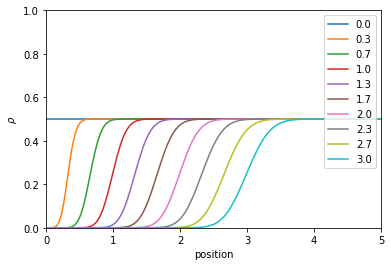

In [4]:
for j in range(ntimes):
    plt.plot(x,ρall[j,:],label=round(times[j],1))
    
plt.xlabel('position')
plt.ylabel(r'$\rho$')
plt.xlim([0,L])
plt.ylim([0,1])
plt.legend(loc=1);

The Current code shows the supernatant-mixture interface. There is zero inlet flux of RBCs.

0.03897475960554324

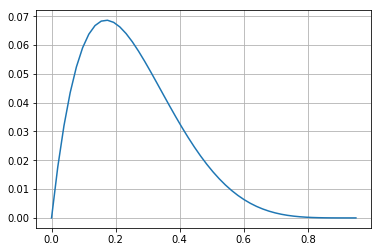

In [58]:
amax=0.95
ρs = np.linspace(0,amax)
plt.plot(ρs,michaels(ρs,2.71,amax=amax)*ρs)
plt.grid()
michaels(0.05,2.71,amax=amax)*0.05

In [50]:
def get_ρ(ρ): 
#     ρ[0] = 0
#     ρ[-1] = 0
    return ρ

def get_c(ρ):
    c = np.ones(len(ρ))
    v = (1-ρ)**2
#     v = michaels(ρ,3)
    return v

def get_q(ρ,volavg=True):
    if volavg:
        return get_c(ρ)*ρ*(1-ρ)
    else:
        return  get_c(ρ) * (get_ρ(ρ))

# def rhsf(ρ,t):
#     qf = get_qf(ρ)
#     dρdt = -1/Δx*(qf[1:]-qf[:-1])
#     return dρdt

def godunov(ρ,t):
    ρ_bc = np.zeros(ngrd+2)
    ρ_bc[-1] = 1.0
    ρ_bc[1:-1] = ρ

    q = get_q(ρ_bc)
    
    # evaluate fluxes at each cell wall 
    qf = np.zeros(ngrdf)
    for i in range(ngrdf):
        if ρ_bc[i] >= ρ_bc[i+1]:
            qf[i] = max(q[i],q[i+1])
        elif ρ_bc[i] <= 0 and 0 <= ρ_bc[i+1]:
            qf[i] = 0
        else:
            qf[i] = min(q[i],q[i+1])
            
    dρdt = 1/Δx*(qf[:-1]-qf[1:])
    return dρdt
        

#---------------------------

ngrd = 100
L    = 1
tend = 3
ntimes = 30

times = np.linspace(0,tend,ntimes)
ngrdf = ngrd+1
Δx    = L/ngrd
xf    = np.linspace(0,L,ngrdf)
x     = (xf[1:] + xf[:-1])/2

ρ0  = np.ones(ngrd)*0.5
ρall = odeint(godunov, ρ0, times)

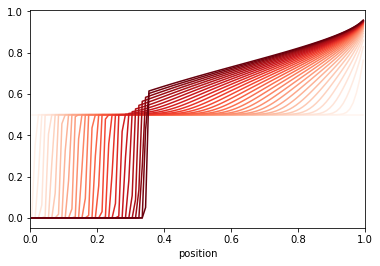

In [52]:
fig = plt.figure()
fig.figsize=(10,10)

color = plt.get_cmap('Reds')
colors = iter(color(np.linspace(0.0,1,ntimes)))
for j in range(ntimes):
    plt.plot(x,ρall[j,:],color=next(colors))

plt.xlabel('position')
plt.xlim([0,L]);
plt.show()

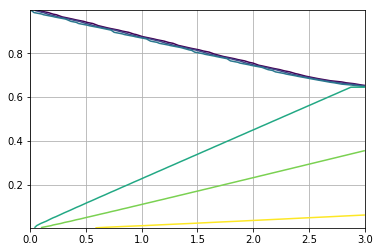

In [53]:
X,T = np.meshgrid(x[::-1],times)
plt.contour(T,X,ρall)
plt.grid()